Import all the necessary libraries 

In [2]:

import warnings
import itertools
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_error


warnings.filterwarnings('ignore')

Load Your DATA


In [5]:
#load data
data = pd.read_csv(r'C:\Users\imtia\PycharmProjects\pythonProject\.venv\Consumption.csv',  
                   parse_dates=['Date'],           
                   index_col='Date')

print("Dataset Shape:", data.shape) # To check dataset shape
print("\nFirst few rows:")
print(data.head()) #For printing first few rows



Dataset Shape: (1498, 1)

First few rows:
            Value (kWh)
Date                   
2016-06-01       29.691
2016-06-02       28.789
2016-06-03       19.247
2016-06-04       22.883
2016-06-05       25.195


Graph for daily electricity consumption from the original data

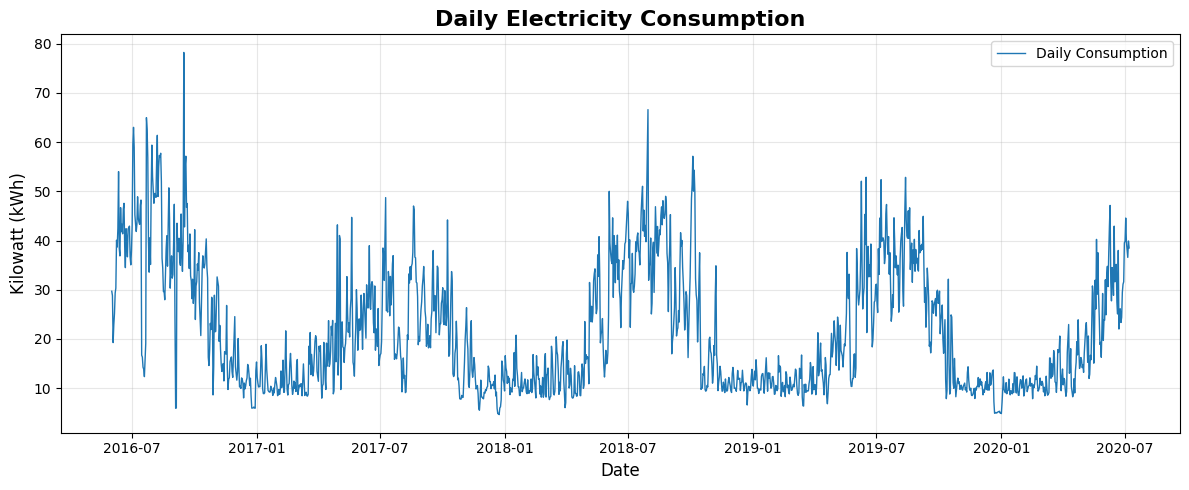

TIME SERIES CHARACTERISTICS
Start Date: 2016-06-01 00:00:00
End Date: 2020-07-07 00:00:00
Number of observations: 1498

Consumption Statistics:
Min: 4.61 kWh
Max: 78.23 kWh
Mean: 21.40 kWh
Std Dev: 12.64 kWh


In [8]:
plt.figure(figsize=(12, 5))
plt.plot(data['Value (kWh)'], label='Daily Consumption', linewidth=1)
plt.title("Daily Electricity Consumption", fontsize=16, fontweight='bold')
plt.xlabel("Date", fontsize=12)
plt.ylabel("Kilowatt (kWh)", fontsize=12) plt.grid(True, alpha=0.3)
plt.legend(loc='best')
plt.tight_layout()
plt.show()


Test the original data for stationarity

In [10]:
# Test stationarity
def adf_test(data):  #Define the ADF test function
    result = adfuller(data)#Perform the ADF test
    print('ADF Statistic: %f' % result[0]) #Print the ADF statistic
    print('p-value: %f' % result[1]) #Print the p-value
    if result[1] <= 0.05: #Check if p-value is less than or equal to 0.05
        print('Reject null hypothesis, data is stationary') #Reject null hypothesis if p-value is <= 0.05
    else: #If p-value is greater than 0.05
        print('Fail to reject null hypothesis, data is non-stationary') #Fail to reject null hypothesis if p-value > 0.05

adf_test(data[['Value (kWh)']])

ADF Statistic: -2.933948
p-value: 0.041540
Reject null hypothesis, data is stationary


Since, the data is stationary (d=0),next we will begin search for p and q value from the graph

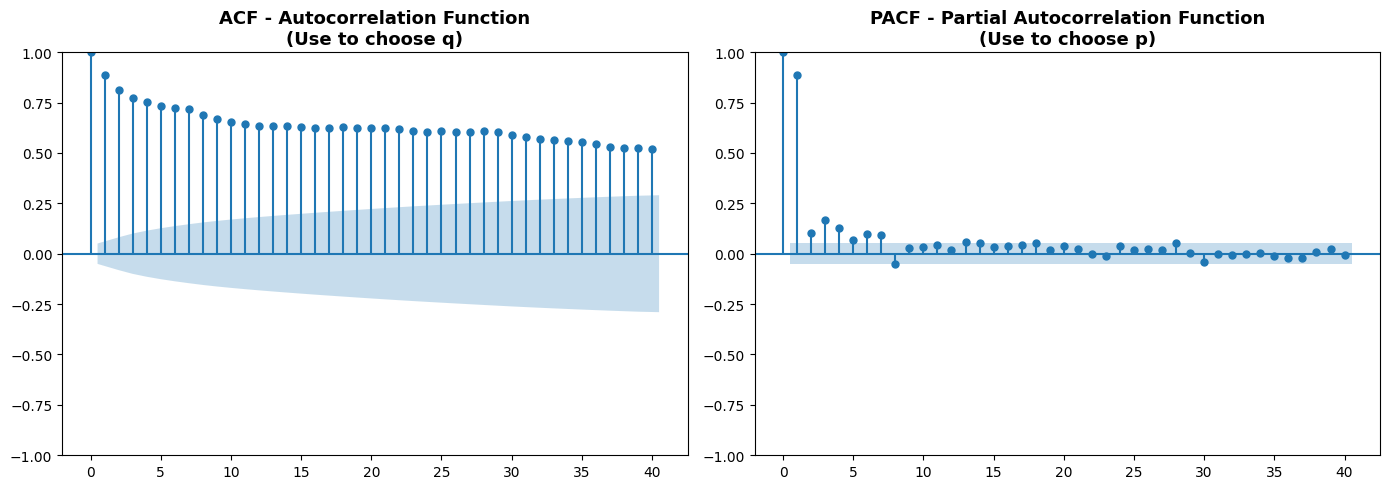

In [17]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# ACF
plot_acf(data['Value (kWh)'], lags=40, ax=axes[0], alpha=0.05)
axes[0].set_title("ACF - Autocorrelation Function\n(Use to choose q)", 
                  fontsize=13, fontweight='bold')

# PACF
plot_pacf(data['Value (kWh)'], lags=40, ax=axes[1], method='ywm', alpha=0.05)
axes[1].set_title("PACF - Partial Autocorrelation Function\n(Use to choose p)", 
                  fontsize=13, fontweight='bold')

plt.tight_layout()
plt.show()

If we cant find out p and q from the graph, we can do grid search to find the best fitted parameter for ARIMA model

In [20]:
# Train/Test split data (80/20)
train_size = int(len(data) * 0.8)
train = data['Value (kWh)'].iloc[:train_size]
test = data['Value (kWh)'].iloc[train_size:]

# Defining parameter ranges based on our analyis
p_range = range(0, 3)  # AR order
d_range = [0]          # We know d=0 from stationarity test
q_range = range(0, 3)  # MA order

best_aic = np.inf
best_bic = np.inf
best_params = None
results_list = []

for p in p_range:
    for d in d_range:
        for q in q_range:
            try:
                model = ARIMA(train, order=(p, d, q))
                model_fit = model.fit()
                
                aic = model_fit.aic
                bic = model_fit.bic
                
                results_list.append({
                    'order': (p, d, q),
                    'AIC': aic,
                    'BIC': bic
                })
                
                # Track best model by AIC
                if aic < best_aic:
                    best_aic = aic
                    best_bic = bic
                    best_params = (p, d, q)
                    
                print(f"ARIMA{(p,d,q)} - AIC: {aic:.2f}, BIC: {bic:.2f}")
                
            except Exception as e:
                print(f"ARIMA{(p,d,q)} - Failed: {str(e)[:50]}")
                continue


print(f"Best Model: ARIMA{best_params}")
print(f"Best AIC: {best_aic:.2f}")
print(f"Best BIC: {best_bic:.2f}")


# Fit the best model
print(f"\nFitting best model: ARIMA{best_params}...")
final_model = ARIMA(train, order=best_params)
final_model_fit = final_model.fit()




ARIMA(0, 0, 0) - AIC: 9562.98, BIC: 9573.16
ARIMA(0, 0, 1) - AIC: 8642.53, BIC: 8657.80
ARIMA(0, 0, 2) - AIC: 8244.24, BIC: 8264.59
ARIMA(1, 0, 0) - AIC: 7731.26, BIC: 7746.53
ARIMA(1, 0, 1) - AIC: 7714.49, BIC: 7734.85
ARIMA(1, 0, 2) - AIC: 7663.94, BIC: 7689.38
ARIMA(2, 0, 0) - AIC: 7721.87, BIC: 7742.23
ARIMA(2, 0, 1) - AIC: 7642.29, BIC: 7667.74
ARIMA(2, 0, 2) - AIC: 7641.81, BIC: 7672.34
Best Model: ARIMA(2, 0, 2)
Best AIC: 7641.81
Best BIC: 7672.34

Fitting best model: ARIMA(2, 0, 2)...


Here, we will begin our forcasting using best fitted model and print its MAE,MAPE and RMSE

In [44]:

n_train = len(train)
start_pos = n_train
end_pos = n_train + len(test) - 1

pred = final_model_fit.get_prediction(start=start_pos, end=end_pos, dynamic=False)
pred_mean = pred.predicted_mean
pred_ci = pred.conf_int()

if not isinstance(pred_mean.index, pd.DatetimeIndex):
    pred_mean.index = test.index
    pred_ci.index = test.index

# metrics
y_true = test
y_pred = pred_mean

rmse = np.sqrt(mean_squared_error(y_true, y_pred))
mae = mean_absolute_error(y_true, y_pred)
mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100

print(f"RMSE (Root Mean Squared Error): {rmse:,.2f}%")
print(f"MAE (Mean Absolute Error): {mae:,.2f}%")
print(f"MAPE (Mean Absolute Percentage Error): {mape:.2f}%")


RMSE (Root Mean Squared Error): 12.60%
MAE (Mean Absolute Error): 11.40%
MAPE (Mean Absolute Percentage Error): 33.12%


Future Forcast and its graph plot

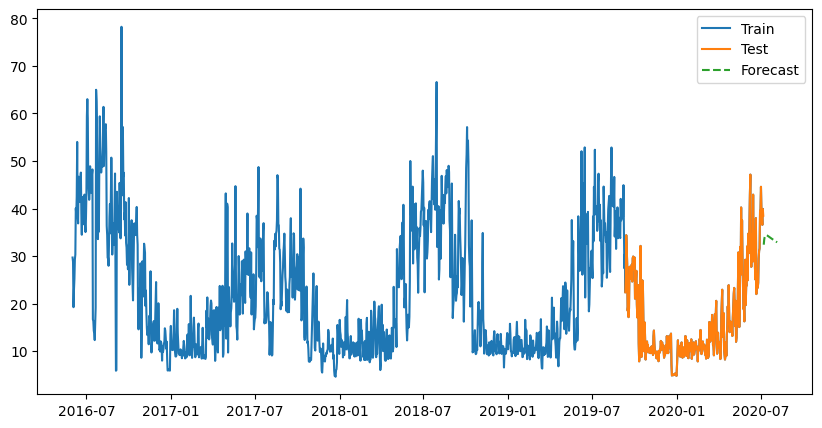

In [42]:
forecast_steps = 30  
fcst = final_model_fit.get_forecast(steps=forecast_steps).predicted_mean


future_index = pd.date_range(start=test.index[-1], periods=forecast_steps+1)[1:] # it will compute future value
fcst.index = future_index

# plot
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 5))
plt.plot(train.index, train, label='Train')
plt.plot(test.index, test, label='Test')
plt.plot(fcst.index, fcst, '--', label='Forecast')
plt.legend()
plt.show()


Rolling-window evaluation for measuring its forcast accuracy 

In [40]:
train_size = int(len(data) * 0.7)  # For 70% train
predictions = []

for i in range(train_size, len(data)):
    train = data['Value (kWh)'][:i]  
    model = ARIMA(train, order=best_params)  #using our best arima model
    model_fit = model.fit()
    pred = model_fit.forecast()[0]  # 1-step ahead
    predictions.append(pred)

actuals = data['Value (kWh)'][train_size:].values
rmse = np.sqrt(mean_squared_error(actuals, predictions))
mae = mean_absolute_error(actuals, predictions)

print(f"Rolling Window RMSE: {rmse:.2f}%")
print(f"Rolling Window MAE: {mae:.2f}%")

Rolling Window RMSE: 5.02%
Rolling Window MAE: 3.45%
